In [10]:
import numpy as np
import os
import pyloudnorm as pyln
from openai import OpenAI

import sys, random  
sys.path.insert(0, '../')
import utils
from utils.audio_generation import sample, get_model
from utils.audio_processing import compress_spectrogram_simple, compress_spectrogram_with_centroid, \
equalize_audio, butter_bandpass_filter, pitch_shift_centroid,change_loudness

from IPython.display import Audio, display
from ipywidgets import widgets

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
# model_name = 'audioldm_16k_crossattn_t5' # Smaller model; Less GPU memory ~[6-9]GB; 
model_name = 'audioldm2-full' # Larger model; More GPU memory ~[12-15] GB; 

#Audio params
loudness_dbfs = -14.0
sample_rate = 16000
stft_channels = 1024
hop_length = 128

# Diffusion params
guidance_scale = 3
n_candidates = 1
batch_size = 1
ddim_steps = 100

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
latent_diffusion = get_model(model_name)

Loading model
Loading AudioLDM-2: audioldm2-full
Loading model on cuda:0
{'log_directory': './log/audiomae_pred', 'precision': 'high', 'data': {'train': ['audiocaps', 'audioset', 'wavcaps', 'audiostock_music_250k', 'free_to_use_sounds', 'epidemic_sound_effects', 'vggsound', 'million_song_dataset'], 'val': 'audiocaps', 'test': 'audiocaps', 'class_label_indices': 'audioset', 'dataloader_add_ons': ['extract_kaldi_fbank_feature', 'extract_vits_phoneme_and_flant5_text', 'waveform_rs_48k']}, 'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'limit_val_batches': 10, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'm

# Foley Interpreter

In [7]:
with open('../config/.env', 'r') as fh:
    vars_dict = dict(
        tuple(line.replace('\n', '').split('='))
        for line in fh.readlines() if not line.startswith('#')
    )

os.environ.update(vars_dict)

In [8]:
client = OpenAI()
def foley_interpreter(txt):
    # content = "Describe a language phrase consisting of a noun verb adjective adverb like "+\
    #         "'a brown cat running purposefully and quickly' that would be a sound which could be also perceivable "+\
    #         "as touch sensation and resembles "+txt+". Use simple words and long descriptions when generating the language phrase. "+\
    #         "Ensure the language phrase is in double quotes."
    content = "Describe a language phrase consisting of a noun, verb, adverb like "+\
                "'a brown cat running purposefully and quickly' that resembles "+txt+" and indicates a sound events occuring and is also perceivable as a touch sensation. "+\
                "Use simple words when generating the language phrase. Ensure the language phrase is in double quotes."
    
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
         {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": content}
      ]
    )

    foley_language_phrase = response.choices[0].message.content
    print(foley_language_phrase)
    print(foley_language_phrase.split('"')[1])
    return foley_language_phrase.split('"')[1]
    

# AI Audio Generator

In [9]:
def audio_generator(foley_language_phrase, latent_diffusion, random_seed):
    audio = sample(latent_diffusion, foley_language_phrase, batch_size=1, ddim_steps=100, guidance_scale=3.0, \
             random_seed=random_seed, disable_tqdmoutput=False)

    return audio

# Dynamic Audio Converter

In [12]:
def audio_post_processor(audio, freq_limit, hop_length, stft_channels, sample_rate, loudness):

    loudness_meter = pyln.Meter(sample_rate)

    original = change_loudness(audio, loudness, loudness_meter)
    original_w_lp = butter_bandpass_filter(audio, highcut=1000, fs=sample_rate, lowcut=None, order=2, btype='lowpass')
    original_w_pitchshifted = pitch_shift_centroid(original_w_lp, limit=250, sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)
    wav_compressed_w_centroid = compress_spectrogram_with_centroid(audio, limit=freq_limit, hop_length=hop_length, stft_channels=stft_channels, \
                                                    sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)

    original_equalized = equalize_audio(audio, sample_rate, loudness_meter=loudness_meter, loudness=loudness)
    original_w_lp_equalized = equalize_audio(original_w_lp, sample_rate, loudness_meter=loudness_meter, loudness=loudness)
    original_w_pitchshifted_equalized = equalize_audio(original_w_pitchshifted, sample_rate, loudness_meter=loudness_meter, loudness=loudness)
    wav_compressed_w_centroid_equalized = equalize_audio(wav_compressed_w_centroid, sample_rate, loudness_meter=loudness_meter, loudness=loudness)

    _ = {\
         'Original': original, \
         'Original + Low Pass': original_w_lp, \
         'Original + Low Pass + Pitch Shifted': original_w_pitchshifted, \
         'Wav Compressed + Centroid': wav_compressed_w_centroid, \
         'Original + Equalized ': original_equalized,\
         'Original + Low Pass + Equalized': original_w_lp_equalized,\
         'Original + Low Pass + Pitch Shifted + Equalized': original_w_pitchshifted_equalized, \
         'Wav Compressed + Centroid + Equalized':wav_compressed_w_centroid_equalized\
        }
    return _

# Examples

Random num =  824
Loudness before =  -24.578291734158523
Loudness after =  -29.99999953854436
Mean Spectral Centroid =  1149.661443555348  Pitch Shift Steps =  26.414508884144738
Loudness before =  -16.246366180163367
Loudness after =  -29.999999999999996
Mean Spectral Centroid =  3135.781888674385
Loudness before =  -23.286104444070467
Loudness after =  -30.000000000000004
Loudness before =  -24.633417868625127
Loudness after =  -30.000000000000004
Loudness before =  -23.73747640036346
Loudness after =  -29.999999999999996
Loudness before =  -15.723485398565638
Loudness after =  -29.999999999999993
Loudness before =  -22.82605881812479
Loudness after =  -30.000000000000004
num rows= 2


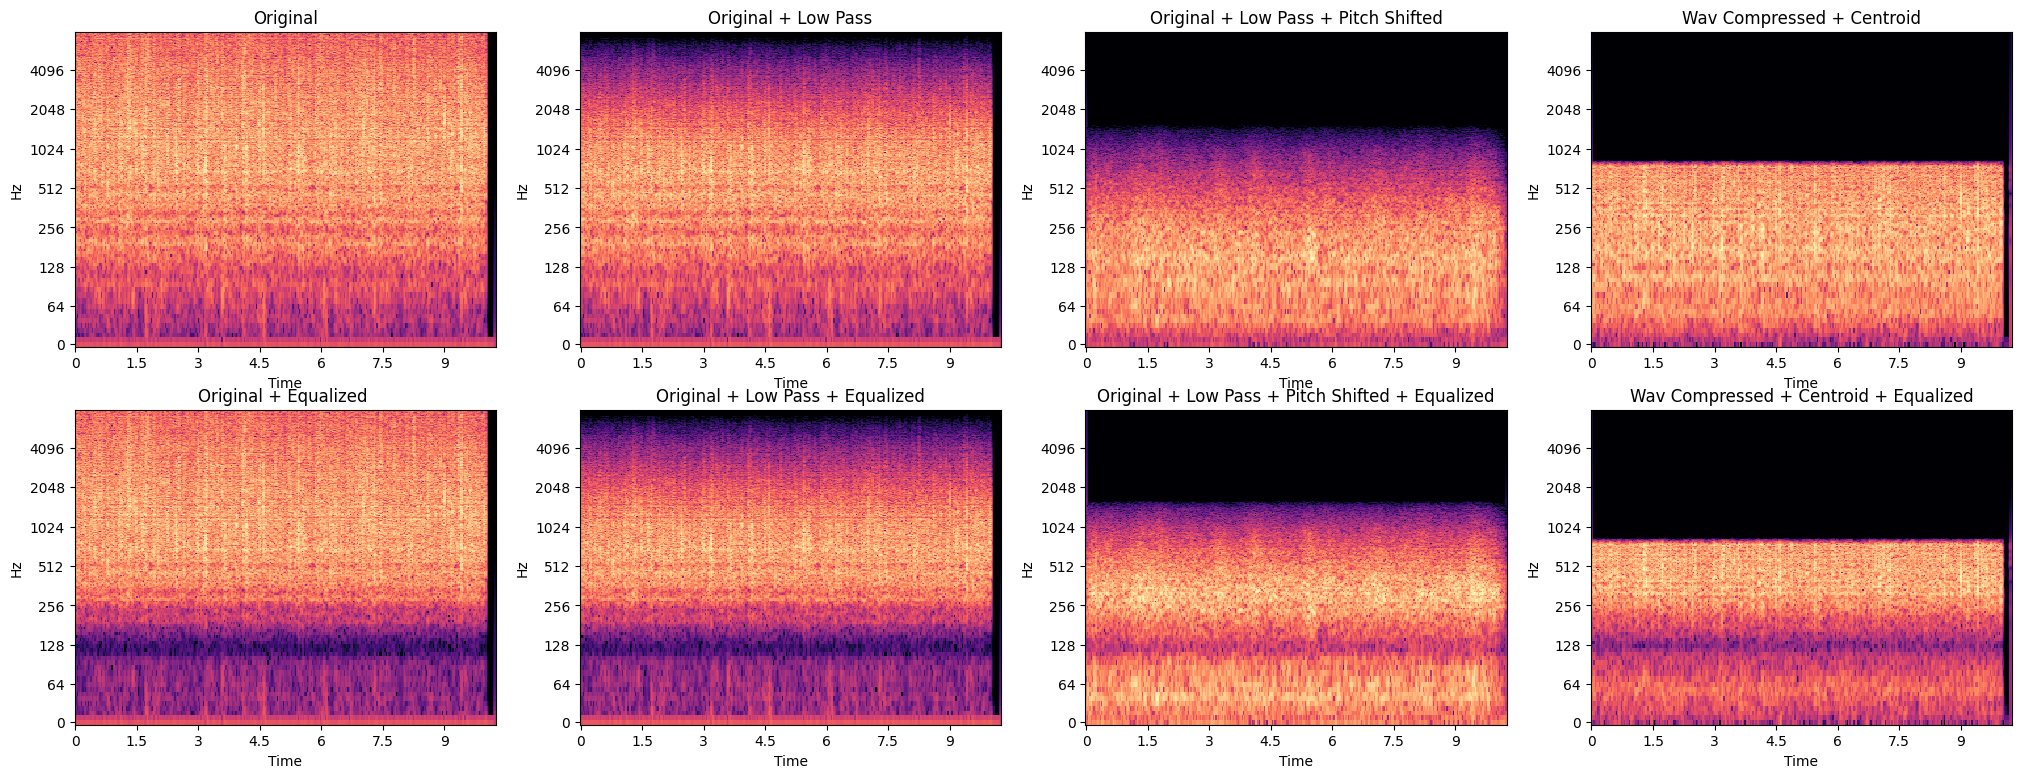

In [22]:
prompt = "heavy rainfall" #Strong droplets softly tapping steadily and persistently

random_num = np.random.randint(0,10000)
print('Random num = ', random_num)
# foley_language_phrase = foley_interpreter(prompt)
# audio = audio_generator(foley_language_phrase, latent_diffusion, random_num)
audio_c = audio_post_processor(audio, freq_limit=1000, hop_length=hop_length, stft_channels=stft_channels, sample_rate=sample_rate, loudness=-30)


all_wavs = []
all_titles = []
for key in audio_c:
    all_wavs.append(audio_c[key])
    all_titles.append(key)

utils.plot_all(all_wavs, all_titles)

audio_widgets = []
for aud in all_wavs[:4]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
top_box = widgets.HBox(audio_widgets)

audio_widgets = []
for aud in all_wavs[4:]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
bottom_box = widgets.HBox(audio_widgets)

widgets.VBox([top_box, bottom_box])

Random num =  8151
"a cheerful child laughing joyfully and playfully"
a cheerful child laughing joyfully and playfully


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.25it/s]


Loudness before =  -18.61172803683833
Loudness after =  -29.999999773966955
Mean Spectral Centroid =  863.2444288115655  Pitch Shift Steps =  21.454092280643295
Loudness before =  -17.94030377382453
Loudness after =  -30.000000000000007
Mean Spectral Centroid =  2058.0841634298486
Loudness before =  -18.69062607223591
Loudness after =  -30.000000000000004
Loudness before =  -19.16670666738086
Loudness after =  -29.999999999999996
Loudness before =  -17.323103611573625
Loudness after =  -30.000000000000004
Loudness before =  -19.371913509624335
Loudness after =  -29.999999999999996
Loudness before =  -20.065087808064575
Loudness after =  -29.999999999999996
num rows= 2


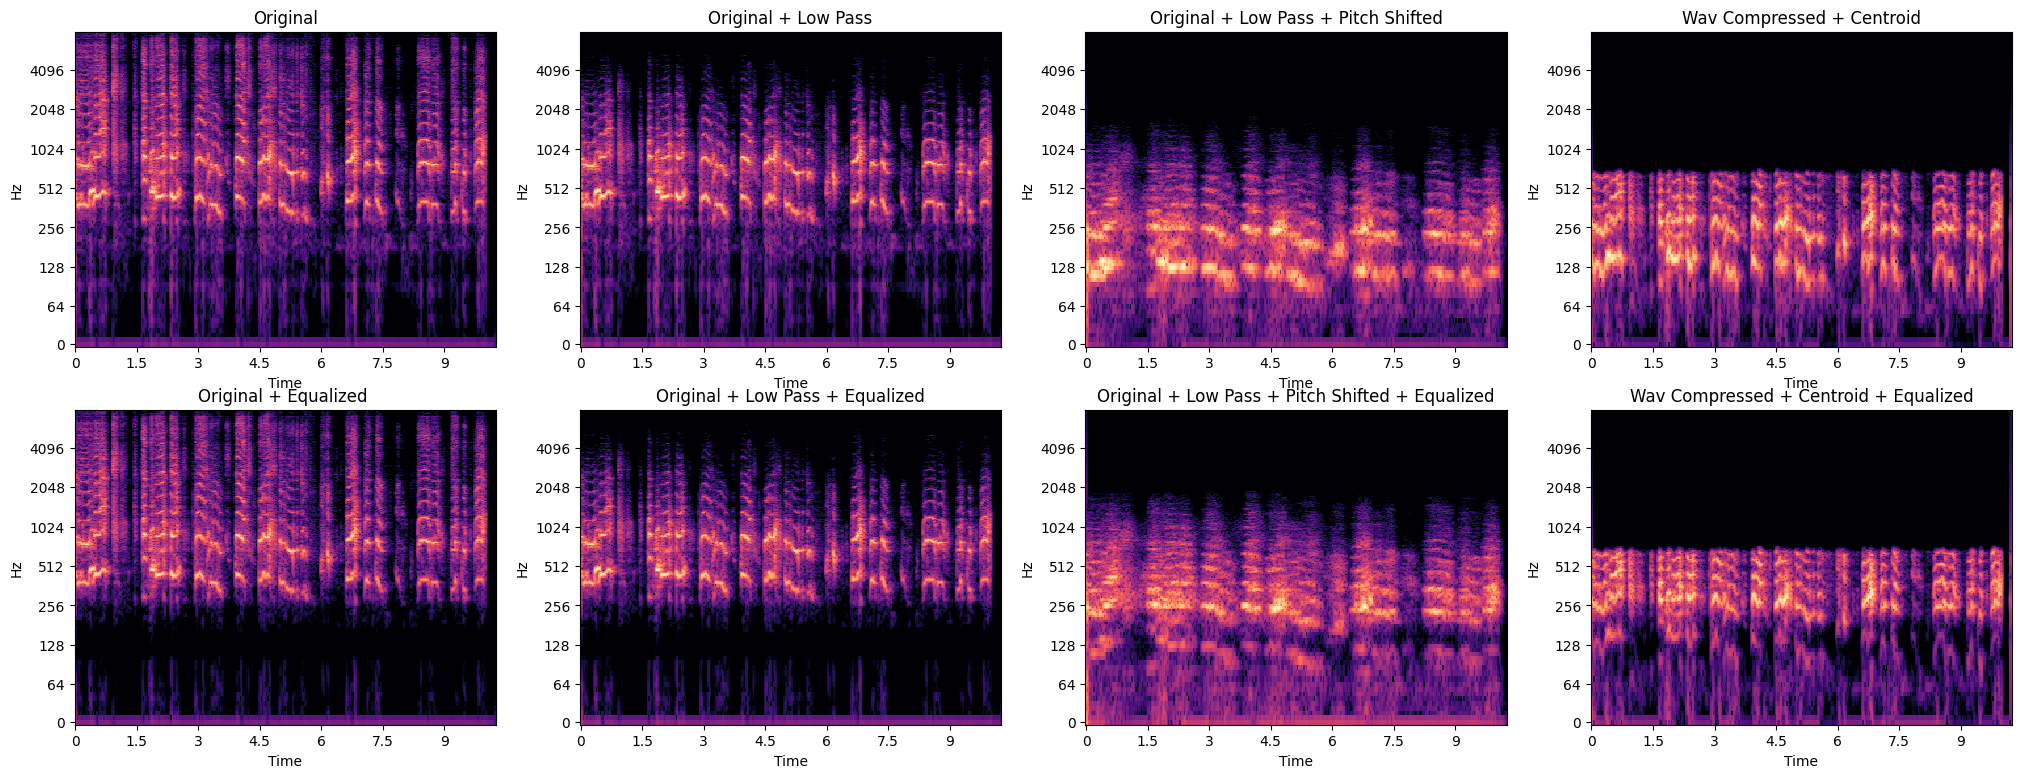

In [23]:
prompt = "feeling of happiness" 

random_num = np.random.randint(0,10000)
print('Random num = ', random_num)
foley_language_phrase = foley_interpreter(prompt)
audio = audio_generator(foley_language_phrase, latent_diffusion, random_num)
audio_c = audio_post_processor(audio, freq_limit=1000, hop_length=hop_length, stft_channels=stft_channels, sample_rate=sample_rate, loudness=-30)


all_wavs = []
all_titles = []
for key in audio_c:
    all_wavs.append(audio_c[key])
    all_titles.append(key)

utils.plot_all(all_wavs, all_titles)

audio_widgets = []
for aud in all_wavs[:4]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
top_box = widgets.HBox(audio_widgets)

audio_widgets = []
for aud in all_wavs[4:]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
bottom_box = widgets.HBox(audio_widgets)

widgets.VBox([top_box, bottom_box])

Random num =  9997
"a metal trashcan clattering loudly and jarringly"
a metal trashcan clattering loudly and jarringly


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.26it/s]


Loudness before =  -22.516537932896224
Loudness after =  -29.829554300517596
Mean Spectral Centroid =  457.8988216960811  Pitch Shift Steps =  10.477209091969861
Loudness before =  -20.14621852160439
Loudness after =  -29.65218062431324
Mean Spectral Centroid =  1762.296266625781
Loudness before =  -23.49060484701618
Loudness after =  -29.999999999999996
Loudness before =  -22.301895452986887
Loudness after =  -29.81439173315143
Loudness before =  -22.982183231317602
Loudness after =  -29.80545935581227
Loudness before =  -20.637198093907013
Loudness after =  -29.65141412514629
Loudness before =  -23.712218254900403
Loudness after =  -30.000000000000004
num rows= 2


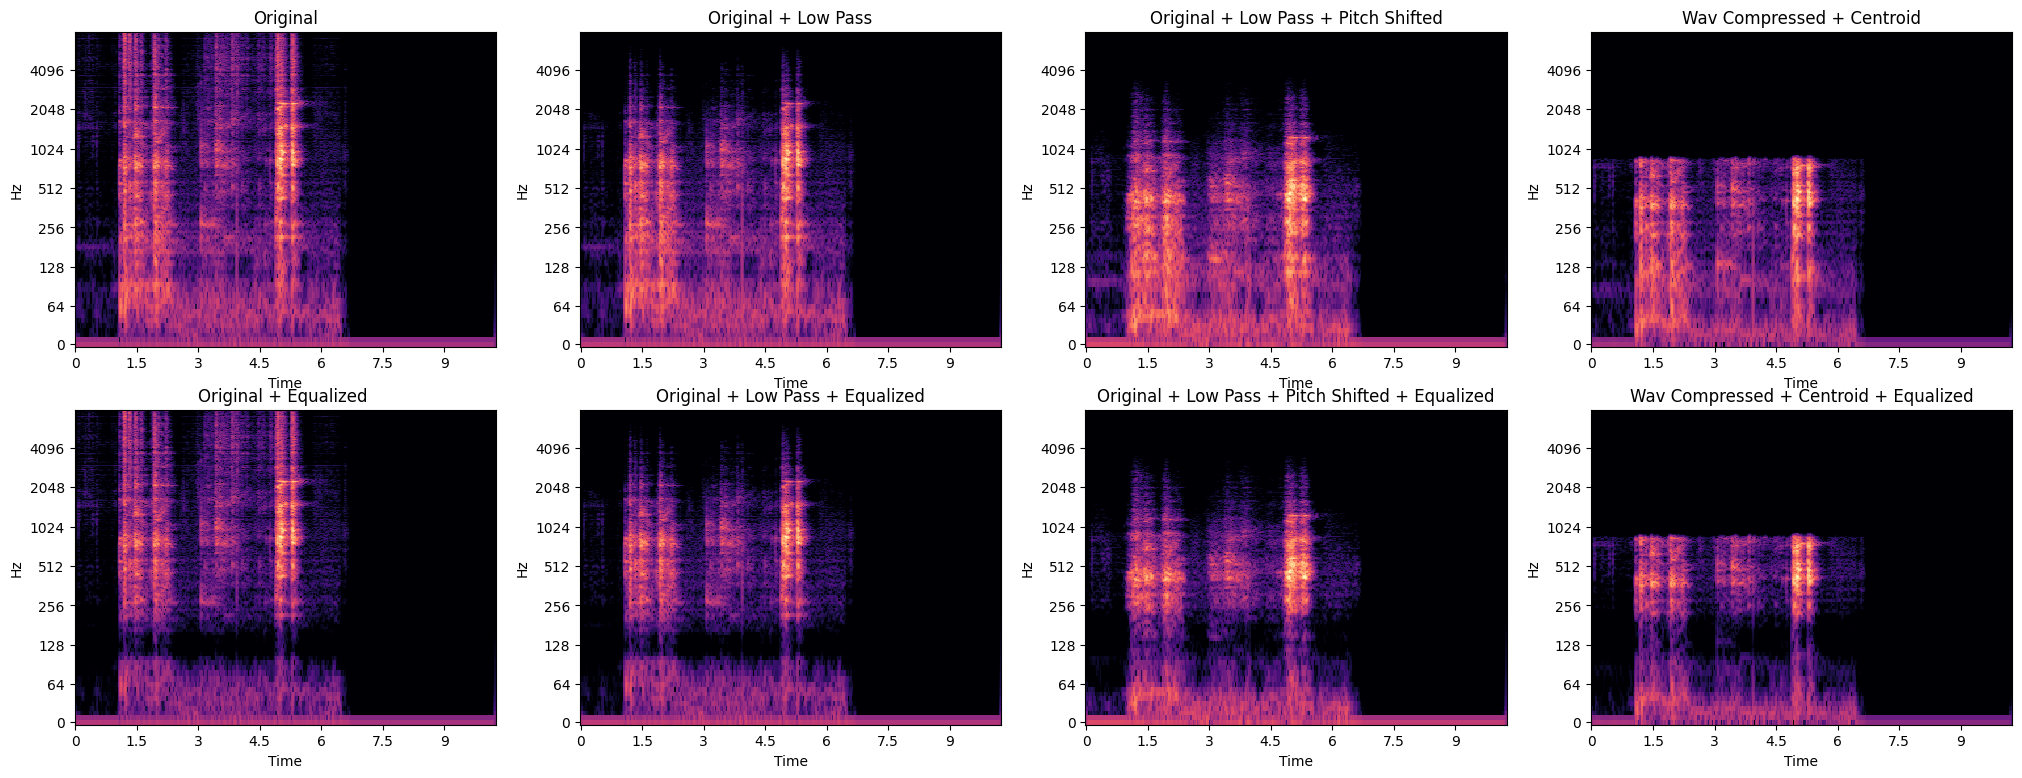

In [24]:
prompt = "trashcan" 

random_num = np.random.randint(0,10000)
print('Random num = ', random_num)
foley_language_phrase = foley_interpreter(prompt)
audio = audio_generator(foley_language_phrase, latent_diffusion, random_num)
audio_c = audio_post_processor(audio, freq_limit=1000, hop_length=hop_length, stft_channels=stft_channels, sample_rate=sample_rate, loudness=-30)


all_wavs = []
all_titles = []
for key in audio_c:
    all_wavs.append(audio_c[key])
    all_titles.append(key)

utils.plot_all(all_wavs, all_titles)

audio_widgets = []
for aud in all_wavs[:4]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
top_box = widgets.HBox(audio_widgets)

audio_widgets = []
for aud in all_wavs[4:]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
bottom_box = widgets.HBox(audio_widgets)

widgets.VBox([top_box, bottom_box])

Random num =  1283


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.31it/s]


Loudness before =  -13.704263885152749
Loudness after =  -30.000000175523812
Mean Spectral Centroid =  1023.0571094645536  Pitch Shift Steps =  24.394640183715747
Loudness before =  -17.859487350108967
Loudness after =  -30.000000000000004
Mean Spectral Centroid =  2276.3551815989053
Loudness before =  -15.32164074986533
Loudness after =  -30.000000000000004
Loudness before =  -13.367490535334724
Loudness after =  -29.999999999999996
Loudness before =  -14.056580077366515
Loudness after =  -29.999999999999996
Loudness before =  -15.768471952777347
Loudness after =  -29.99999999999999
Loudness before =  -15.633579520304611
Loudness after =  -29.999999999999996
num rows= 2


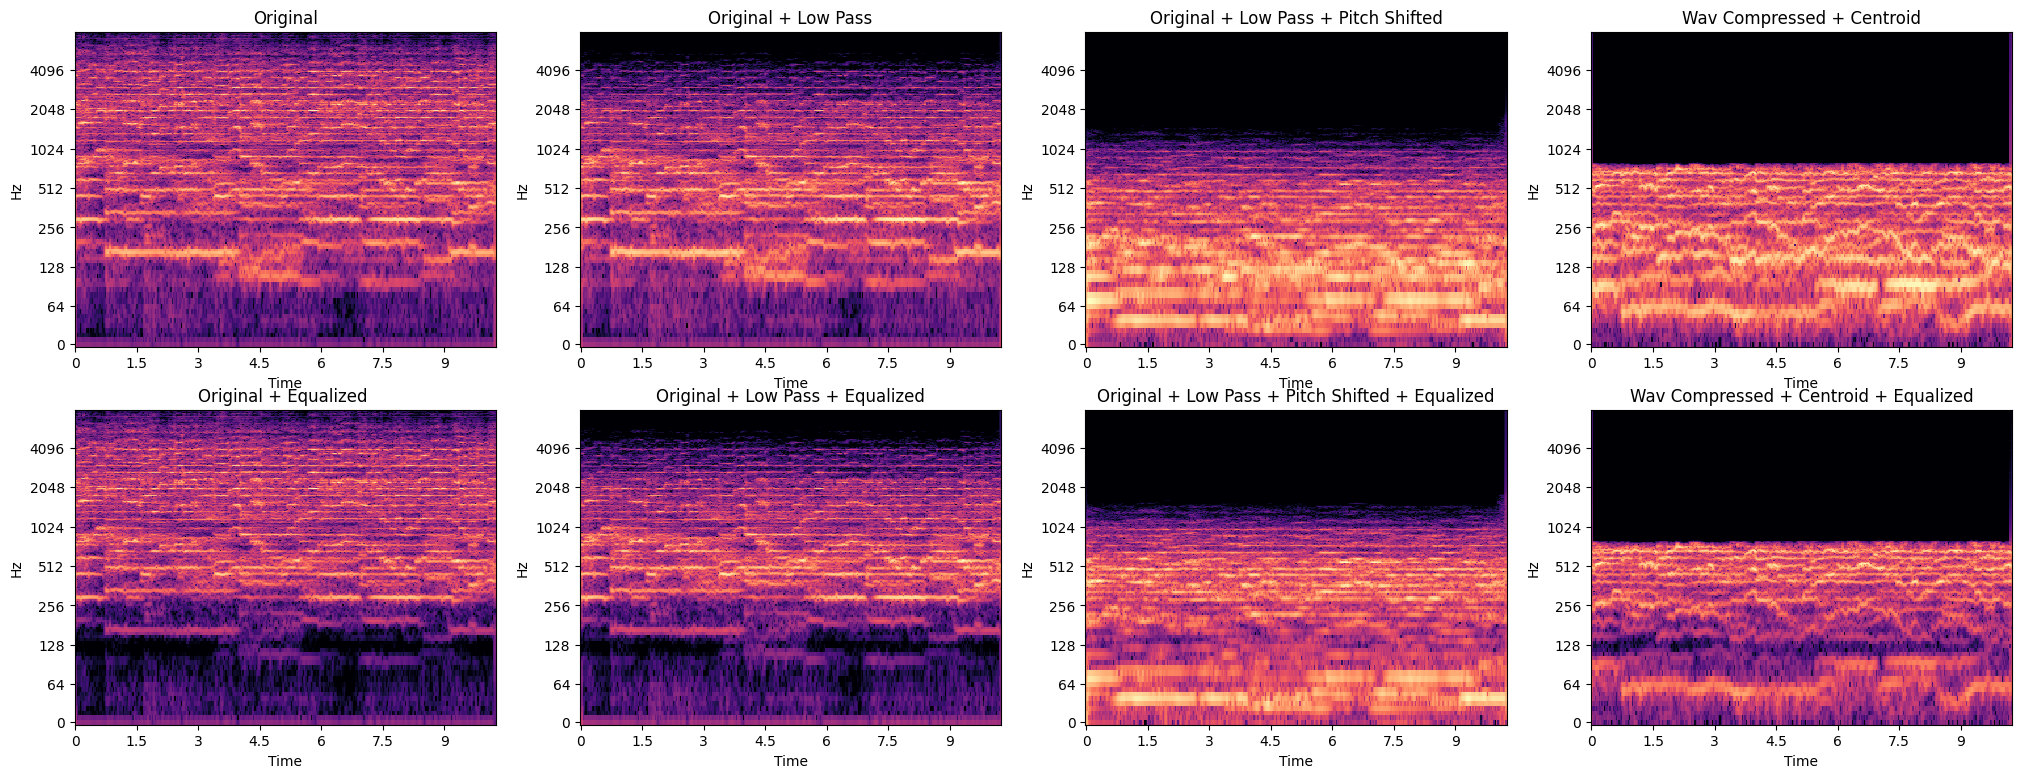

In [25]:
prompt = "A violin playing mournfully"

random_num = np.random.randint(0,10000)
print('Random num = ', random_num)
# foley_language_phrase = foley_interpreter(prompt)
audio = audio_generator(prompt, latent_diffusion, random_num)
audio_c = audio_post_processor(audio, freq_limit=1000, hop_length=hop_length, stft_channels=stft_channels, sample_rate=sample_rate, loudness=-30)


all_wavs = []
all_titles = []
for key in audio_c:
    all_wavs.append(audio_c[key])
    all_titles.append(key)

utils.plot_all(all_wavs, all_titles)

audio_widgets = []
for aud in all_wavs[:4]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
top_box = widgets.HBox(audio_widgets)

audio_widgets = []
for aud in all_wavs[4:]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
bottom_box = widgets.HBox(audio_widgets)

widgets.VBox([top_box, bottom_box])

"a loud scream echoing eerily and chillingly"
a loud scream echoing eerily and chillingly


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.21it/s]


Loudness before =  -10.2719663908601
Loudness after =  -30.0000002274021
Mean Spectral Centroid =  771.3197717302204  Pitch Shift Steps =  19.504811975985646
Loudness before =  -13.851818542559233
Loudness after =  -29.999999999999996
Mean Spectral Centroid =  1485.2112787343763
Loudness before =  -16.58556869446795
Loudness after =  -29.999999999999996
Loudness before =  -10.38140902188796
Loudness after =  -29.999999999999996
Loudness before =  -13.533984567172833
Loudness after =  -29.999999999999996
Loudness before =  -12.83354583261065
Loudness after =  -30.000000000000004
Loudness before =  -16.34835000552237
Loudness after =  -30.000000000000004
num rows= 2


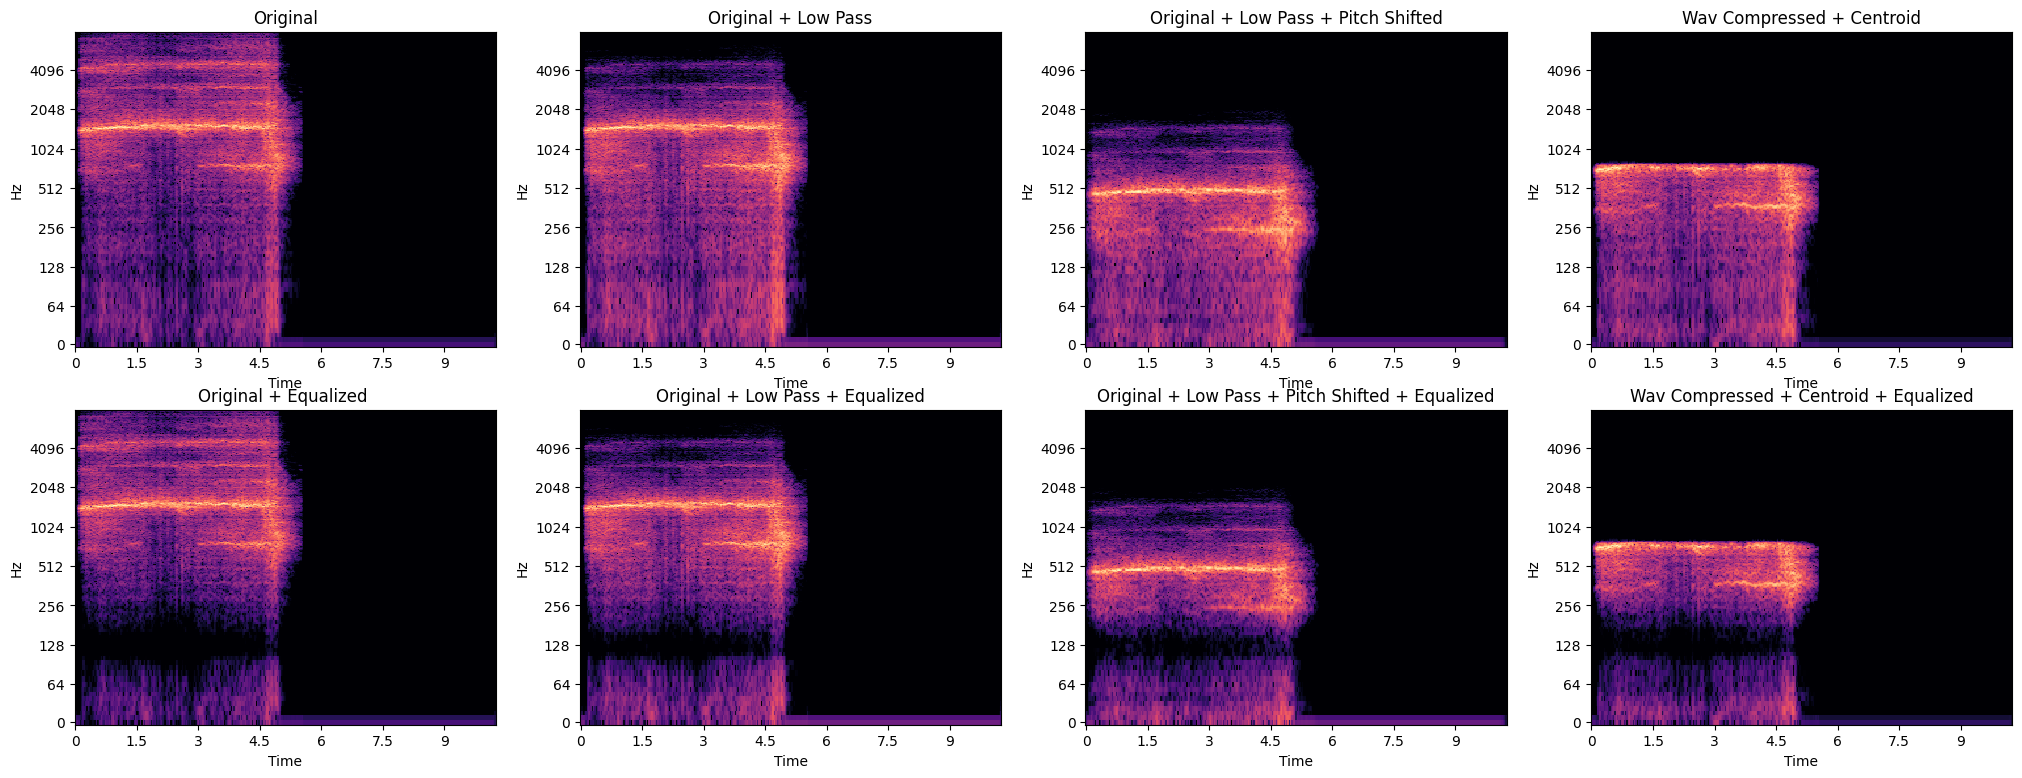

In [27]:
prompt = "a feeling of fear" 

foley_language_phrase = foley_interpreter(prompt)
audio = audio_generator(foley_language_phrase, latent_diffusion, np.random.randint(0,10000))
audio_c = audio_post_processor(audio, freq_limit=1000, hop_length=hop_length, stft_channels=stft_channels, sample_rate=sample_rate, loudness=-30)

all_wavs = []
all_titles = []
for key in audio_c:
    all_wavs.append(audio_c[key])
    all_titles.append(key)

utils.plot_all(all_wavs, all_titles)

audio_widgets = []
for aud in all_wavs[:4]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
top_box = widgets.HBox(audio_widgets)

audio_widgets = []
for aud in all_wavs[4:]:
    out = widgets.Output()
    with out:
        display(Audio(data=aud, rate=sample_rate))
    audio_widgets.append(out)
bottom_box = widgets.HBox(audio_widgets)

widgets.VBox([top_box, bottom_box])